In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import sys

In [ ]:
!wget -nc https://www.cp.jku.at/datasets/MMTD/mmtd.zip

--2024-11-18 12:00:43--  https://www.cp.jku.at/datasets/MMTD/mmtd.zip
Resolving www.cp.jku.at (www.cp.jku.at)... 140.78.124.154
Connecting to www.cp.jku.at (www.cp.jku.at)|140.78.124.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134305875 (128M) [application/zip]
Saving to: ‘mmtd.zip’

mmtd.zip            100%[===================>] 128.08M  5.58MB/s    in 24s     

2024-11-18 12:01:09 (5.23 MB/s) - ‘mmtd.zip’ saved [134305875/134305875]



In [ ]:
!unzip -n mmtd.zip

Archive:  mmtd.zip
  inflating: mmtd.txt                


In [ ]:
from IPython import get_ipython

ipython = get_ipython()

def setup():
    ipython.magic("sx pip -qq install dask[complete]")
    ipython.magic("sx pip -qq install dask distributed")
    ipython.magic("sx pip -qq install mimesis")
    ipython.magic("sx pip -qq install dask")
    print("Setup completed successfully")
    return

setup()

Setup completed successfully


In [ ]:
#use dask to read this large file
import dask
import dask.dataframe as dd
df = dd.read_csv('/content/mmtd.txt', delimiter='\t', assume_missing=True)

In [ ]:
#get 100K rows
df = df.head(500000)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:8164: UserWarning: Insufficient elements for `head`. 500000 elements requested, only 77974 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


In [ ]:
#select only tweet_userid and track_title
df.head()

,tweet_id,tweet_tweetId,tweet_userId,tweet_artistId,tweet_trackId,tweet_datetime,tweet_unixtime,tweet_weekday,tweet_longitude,tweet_latitude,...,lang_wuu,lang_xal,lang_xh,lang_yao,lang_yap,lang_yo,lang_yue,lang_za,lang_zh,lang_zu
0,1.0,1.674081e+17,24842995.0,25040.0,420585.0,2012-02-09 00:43:00,1.328745e+09,3.0,0.126573,52.1976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.674083e+17,77147006.0,122992.0,2106213.0,2012-02-09 00:43:32,1.328745e+09,3.0,-80.199900,36.0349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.851898e+17,174626103.0,468091.0,8030020.0,2012-03-29 02:21:01,1.332980e+09,3.0,-0.142822,51.5207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,2.299403e+17,538669914.0,67904.0,1210996.0,2012-07-30 14:03:43,1.343650e+09,0.0,2.334750,48.9009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,1.674084e+17,245555020.0,223140.0,4019560.0,2012-02-09 00:44:13,1.328745e+09,3.0,-47.818000,-21.2134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#select tweet_id, tweet_userId , track_title
df = df[['tweet_id', 'tweet_userId', 'track_title','tweet_artistId', 'artist_name']]

In [ ]:
#combine tracktitle and artistid and artistname into one column
df['track_title'] = df.apply(lambda x : x['track_title'] + '--' + x['artist_name'], axis=1)

In [ ]:
df.head()

,tweet_id,tweet_userId,track_title,tweet_artistId,artist_name
0,1.0,24842995.0,Agnus dei--Anonymous 4,25040.0,Anonymous 4
1,2.0,77147006.0,Find Your Love--Drake,122992.0,Drake
2,3.0,174626103.0,Hey Mr DJ--Van Morrison,468091.0,Van Morrison
3,4.0,538669914.0,Call Me Maybe--Carly Rae Jepsen,67904.0,Carly Rae Jepsen
4,5.0,245555020.0,4 Minutes--Justin Timberlake,223140.0,Justin Timberlake


In [ ]:
#create a dataframe of title , artistid and name with title as unique
#df_title_artist = df[['track_title', 'tweet_artistId', 'artist_name']]

In [ ]:
#df_title_artist.head()

In [ ]:
#keep only unique track_title
#df_title_artist.drop_duplicates().reset_index()

In [ ]:
#group by tweet_userId , index as false
df = df.groupby(['tweet_userId', 'track_title']).size().reset_index(name='count')

In [ ]:
df.head()

,tweet_userId,track_title,count
0,2695.0,The Rip Tide--Beirut,1
1,11526.0,We Ride--Rihanna,1
2,12924.0,Hangover--Taio Cruz,1
3,20503.0,Rumour Has It--Adele,1
4,21803.0,The Downward Spiral--Nine Inch Nails,1


In [ ]:
#get the max and min value of count and print
max_count = df['count'].max()
min_count = df['count'].min()
print(max_count)
print(min_count)

93
1


In [ ]:
#drop rows where count = 1
df = df[df['count'] > 1]

<Axes: ylabel='Frequency'>

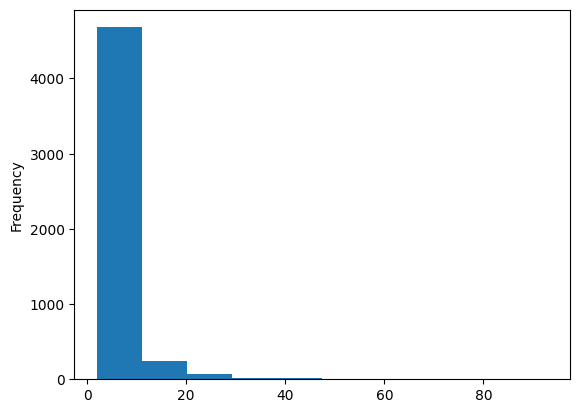

In [ ]:
#plot the distribution of count
df['count'].plot.hist(bins=10)

In [ ]:
#for the count values > 10 make it as 10
df.loc[df['count'] > 10, 'count'] = 10

<Axes: ylabel='Frequency'>

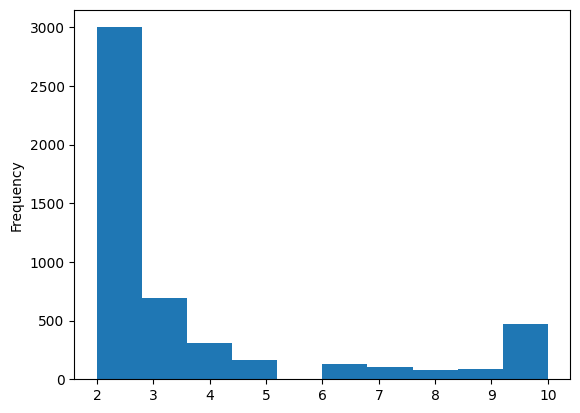

In [ ]:
df['count'].plot.hist(bins=10)

In [ ]:
mean = df.groupby(by='tweet_userId', as_index=False)['count'].mean()

In [ ]:
df = df.merge(mean, suffixes=('','_mean'), on='tweet_userId')

In [ ]:
df['norm_count'] = df['count'] - df['count_mean']

In [ ]:
df.head()

,tweet_userId,track_title,count,count_mean,norm_count
0,10845582.0,Confidência--Falamansa,2,2.0,0.0
1,14099909.0,When I Was a Youngster--Rizzle Kicks,2,2.0,0.0
2,14382368.0,Worldwide Choppers--Yelawolf,2,2.0,0.0
3,14443016.0,Beautiful Things--Gungor,2,2.0,0.0
4,14443016.0,Without You--David Guetta,2,2.0,0.0


In [ ]:
df[df['tweet_userId'] == 10845582.0].head()

,tweet_userId,track_title,count,count_mean,norm_count
0,10845582.0,Confidência--Falamansa,2,2.0,0.0


In [ ]:
df = df[df['norm_count'] > 0 ]

<Axes: ylabel='Frequency'>

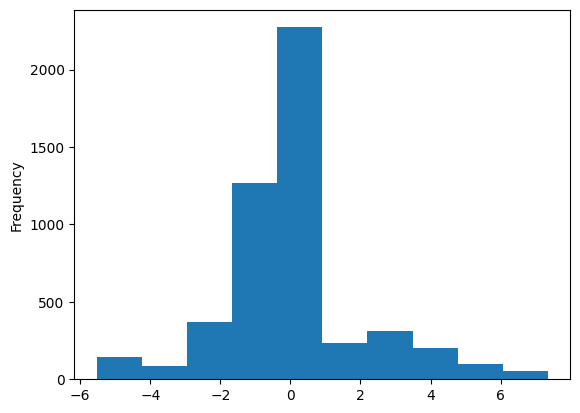

In [ ]:
df['norm_count'].plot.hist(bins=10)

In [ ]:
R = csr_matrix(pd.crosstab(df['track_title'], df['tweet_userId'],
                           values=df['count'], aggfunc='sum').fillna(0).values)

In [ ]:
#write the df to a file
def saveDataFrameToCSV( dataframe, dataset_name ):
    base_dir = '/content/input/item2item'
    save_dir = os.path.join(base_dir, dataset_name)
    os.makedirs(save_dir, exist_ok=True)
    input_file = os.path.join(save_dir, 'input.csv')
    dataframe.to_csv(input_file, index=False)

saveDataFrameToCSV(df, 'music10k')

In [ ]:
#convert df to numpy array
np_ratings = df.to_numpy()
#show first 5 rows
np_ratings[:5]
#show shape
np_ratings.shape

(5042, 5)

In [ ]:
np_ratings[:, 1]

array(['Confidência--Falamansa', 'When I Was a Youngster--Rizzle Kicks',
       'Worldwide Choppers--Yelawolf', ..., "I'm in Love--Meiko",
       'Where Have You Been--Rihanna', 'Kiss You Up--Miranda Cosgrove'],
      dtype=object)

In [ ]:
def create_model(rating_matrix, k=20, metric="cosine"):
    """
    :param R : numpy array of item representations
    :param k : number of nearest neighbors to return
    :return model : our knn model
    """
    model = NearestNeighbors(metric=metric, n_neighbors=k+1, algorithm='brute')
    model.fit(rating_matrix)
    return model

In [ ]:
def nearest_neighbors(rating_matrix, model):
    """
    compute the top n similar items for each item.
    :param rating_matrix : items representations
    :param model : nearest neighbors model
    :return similarities, neighbors
    """
    similarities, neighbors = model.kneighbors(rating_matrix)
    return similarities[:,1:], neighbors[:,1:]

In [ ]:
import sys

In [ ]:
def save_similarities(similarities, neighbors, dataset_name):
    base_dir = '/content/weights/item2item'
    save_dir = os.path.join(base_dir, dataset_name)
    os.makedirs(save_dir, exist_ok=True)
    similarities_file_name = os.path.join(save_dir, 'similarities.npy')
    neighbors_file_name = os.path.join(save_dir, 'neighbors.npy')
    try:
        np.save(similarities_file_name, similarities)
        np.save(neighbors_file_name, neighbors)
    except ValueError as error:
        print(f"An error occured when saving similarities, due to : \n ValueError : {error}")


def load_similarities(dataset_name, k=20):
    base_dir = '/content/weights/item2item'
    save_dir = os.path.join(base_dir, dataset_name)
    similiraties_file = os.path.join(save_dir, 'similarities.npy')
    neighbors_file = os.path.join(save_dir, 'neighbors.npy')
    similarities = np.load(similiraties_file)
    neighbors = np.load(neighbors_file)
    return similarities[:,:k], neighbors[:,:k]


def cosine(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


def adjusted_cosine(np_ratings, nb_items, dataset_name):
    similarities = np.zeros(shape=(nb_items, nb_items))
    similarities.fill(-1)

    def _progress(count):
        sys.stdout.write('\rComputing similarities. Progress status : %.1f%%' % (float(count / nb_items)*100.0))
        sys.stdout.flush()

    items = sorted(df.track_title.unique())
    for cnt, i in enumerate(items[:-1]):
        cnt2 = cnt+1
        for cnt2, j in enumerate(items[cnt2:]):
            scores = np_ratings[(np_ratings[:, 1] == i) | (np_ratings[:, 1] == j), :]
            vals, count = np.unique(scores[:,0], return_counts = True)
            scores = scores[np.isin(scores[:,0], vals[count > 1]),:]

            if scores.shape[0] > 2:
                x = scores[scores[:, 1] == i, 4]
                y = scores[scores[:, 1] == j, 4]
                w = cosine(x, y)

                similarities[cnt, cnt2] = w
                similarities[cnt2, cnt] = w
        _progress(cnt)
    _progress(nb_items)

    # get neighbors by their neighbors in decreasing order of similarities
    neighbors = np.flip(np.argsort(similarities), axis=1)

    # sort similarities in decreasing order
    similarities = np.flip(np.sort(similarities), axis=1)

    # save similarities to disk
    save_similarities(similarities, neighbors, dataset_name=dataset_name)

    return similarities, neighbors

In [ ]:
nb_items = df.track_title.nunique()
similarities, neighbors = adjusted_cosine(np_ratings, nb_items=nb_items, dataset_name='music10k')

Computing similarities. Progress status : 100.0%

In [ ]:
print('neighbors shape : ', neighbors.shape)
print('similarities shape : ', similarities.shape)

neighbors shape :  (4006, 4006)
similarities shape :  (4006, 4006)


In [ ]:
items = sorted(df.track_title.unique())
#create a map of item to its index in items
item_to_index = {}
for i, item in enumerate(items):
    item_to_index[item] = i

In [ ]:
#write this dictionary to a file
def save_item_to_index(item_to_index, dataset_name):
    base_dir = '/content/weights/item2item'
    save_dir = os.path.join(base_dir, dataset_name)
    item_to_index_file = os.path.join(save_dir, 'item_to_index.txt')
    with open(item_to_index_file, 'w') as f:
        for key, value in item_to_index.items():
            f.write('%s:%s\n' % (key, value))

save_item_to_index(item_to_index, 'music10k')

In [ ]:
def load_item_to_index(dataset_name):
    base_dir = '/content/weights/item2item'
    save_dir = os.path.join(base_dir, dataset_name)
    item_to_index_file = os.path.join(save_dir, 'item_to_index.txt')
    item_to_index = {}
    with open(item_to_index_file, 'r') as f:
        for line in f:
            (key, val) = line.split(':')
            item_to_index[key] = int(val)
    return item_to_index

In [ ]:
def candidate_items(userid):
    """
    :param userid : user id for which we wish to find candidate items
    :return : I_u, candidates
    """

    # 1. Finding the set I_u of items already rated by user userid
    I_u = np_ratings[np_ratings[:, 0] == userid]
    I_u = I_u[:, 1]

    # 2. Taking the union of similar items for all items in I_u to form the set of candidate items
    c = set()

    for iid in I_u:
        #get index of iid
        title_index = item_to_index[iid]
        # add the neighbors of item iid in the set of candidate items
        c.update(neighbors[title_index])

    I_u_iid = [ item_to_index[iid] for iid in I_u]
    c = list(c)
    # 3. exclude from the set C all items in I_u.
    #candidates = np.setdiff1d(c, I_u, assume_unique=True)
    candidates = np.setdiff1d(c, I_u_iid, assume_unique=True)

    return I_u, candidates

In [ ]:
#read the first tweet_userId from df
test_user_id = df.iloc[10]['tweet_userId']
print(test_user_id)
i_u, u_candidates = candidate_items(test_user_id)

16566714.0


In [ ]:
print('number of items purchased by user 1 : ', len(i_u))
print('number of candidate items for user 1 : ', len(u_candidates))

number of items purchased by user 1 :  2
number of candidate items for user 1 :  4004


In [ ]:
def similarity_with_Iu(c, I_u):
    """
    compute similarity between an item c and a set of items I_u. For each item i in I_u, get similarity between
    i and c, if c exists in the set of items similar to itemid.
    :param c : itemid of a candidate item
    :param I_u : set of items already purchased by a given user
    :return w : similarity between c and I_u
    """
    w = 0
    for iid in I_u :
        # get similarity between itemid and c, if c is one of the k nearest neighbors of itemid
        title_index = item_to_index[iid]
        if c in neighbors[title_index] :
            w = w + similarities[title_index, neighbors[title_index] == c][0]
    return w

In [ ]:
def rank_candidates(candidates, I_u):
    """
    rank candidate items according to their similarities with i_u
    :param candidates : list of candidate items
    :param I_u : list of items purchased by the user
    :return ranked_candidates : dataframe of candidate items, ranked in descending order of similarities with I_u
    """

    # list of candidate items mapped to their corresponding similarities to I_u
    sims = [similarity_with_Iu(c, I_u) for c in candidates]
    mapping = list(zip(candidates, sims))

    ranked_candidates = sorted(mapping, key=lambda couple:couple[1], reverse=True)
    return ranked_candidates

In [ ]:
df_item_index1 = pd.DataFrame(list(item_to_index.items()), columns=['track_title', 'itemid'])
df_item_index1

,track_title,itemid
0,10.15 Saturday Night--The Cure,0
1,100 Years--Five for Fighting,1
2,1000 und 1 Nacht--Klaus Lage Band,2
3,1234--Feist,3
4,18 and Life--Skid Row,4
...,...,...
4001,ill Manors--Plan B,4001
4002,jangan pernah berubah--Marcell,4002
4003,la Bambola--Patty Bravo,4003
4004,missing--Kylee,4004


In [ ]:
#filter out df_title_artist with tracts present in df_item_index1
df_title_artist = df_title_artist[df_title_artist['track_title'].isin(df_item_index1['track_title'])]

NameError: name 'df_title_artist' is not defined

In [ ]:
df_title_artist = df_title_artist.drop_duplicates()

In [ ]:
df_title_artist.head()

,track_title,tweet_artistId,artist_name
1,Find Your Love,122992.0,Drake
3,Call Me Maybe,67904.0,Carly Rae Jepsen
4,4 Minutes,223140.0,Justin Timberlake
7,Far Away,462593.0,Tyga
9,Stand Back,17082.0,Allman Brothers Band


In [ ]:
def topn_recommendation(userid, N=30):
    """
    Produce top-N recommendation for a given user
    :param userid : user for which we produce top-N recommendation
    :param n : length of the top-N recommendation list
    :return topn
    """
    # find candidate items
    I_u, candidates = candidate_items(userid)

    # rank candidate items according to their similarities with I_u
    ranked_candidates = rank_candidates(candidates, I_u)

    # get the first N row of ranked_candidates to build the top N recommendation list
    topn = pd.DataFrame(ranked_candidates[:N], columns=['itemid','similarity_with_Iu'])
    topn = pd.merge(topn, df_item_index1, on='itemid', how='inner')
    #add columns for artist id and artist name to topn
    #topn = pd.merge(topn, df_title_artist[['track_title', 'tweet_artistId', 'artist_name']], on='track_title', how='inner')
    return topn

In [ ]:
topn_recommendation(test_user_id)

,itemid,similarity_with_Iu,track_title
0,602,-0.051247,Cinema--Benni Benassi
1,256,-0.066472,Back to December--Taylor Swift
2,576,-0.076741,Changing the Rain--The Horrors
3,406,-0.144635,Blue Sky--Common
4,471,-0.195989,Broken Bone--Iceage
5,669,-0.195989,Crazy--Patsy Cline
6,427,-0.244993,Boring--The Pierces
7,234,-0.275603,Autobahn--Kraftwerk
8,428,-0.408203,Born Loose--Rod Stewart
9,338,-0.485216,Besser als Liebe--Neil Hickethier


In [ ]:
#for each user in the df , calculate Iu and len
userids =[]

for userid in df.tweet_userId.unique():
    I_u, candidates = candidate_items(userid)
    if (len(I_u) > 4):
        userids.append(userid)

print(len(userids))

53


In [ ]:
#print the track_titles of userid[51]
df[df['tweet_userId'] == userids[51]][['track_title', 'norm_count']]

,track_title,norm_count
4762,24000 Baci--Aylin Prandi,-2.674528
4763,A Forest--Nouvelle Vague,-3.674528
4764,A Lover Spurned--Marc Almond,2.325472
4765,A Night Like This--Caro Emerald,0.325472
4766,Addicted--Waldeck,-3.674528
...,...,...
4969,You Owe Me Some Kind of Love--Chris Isaak,4.325472
4970,You Will Never Know--Imany,1.325472
4971,You do Something to Me--Paul Weller,0.325472
4972,You're Not Alone--Mads Langer,-1.674528


In [ ]:
topn_recommendation(userids[51])

,itemid,similarity_with_Iu,track_title
0,916,-196.182979,Echt--Glasperlenspiel
1,949,-197.361713,Empire state of mind--Alicia Keys
2,1327,-198.069690,Heart Skips a Beat--Olly Murs
3,882,-199.212905,Drive By--Train
4,516,-199.301946,Call Me Maybe--Carly Rae Jepsen
5,522,-199.979631,Called Out in the Dark--Snow Patrol
6,2081,-200.619394,Ma Cherie--The Beat Shakers
7,441,-201.028573,Boyfriend--Justin Bieber
8,1246,-201.345654,Goodbye Kiss--Kasabian
9,626,-201.606187,Colour Me In--Rea


In [ ]:
#save the unique user ids
def save_unique_user_ids(dataset_name):
    base_dir = '/content/weights/item2item'
    save_dir = os.path.join(base_dir, dataset_name)
    unique_user_ids_file = os.path.join(save_dir, 'unique_user_ids.txt')
    np.savetxt(unique_user_ids_file, userids, fmt='%s')

In [ ]:
save_unique_user_ids('music10k')

In [ ]:
#copy 20 neighbors of unique users
def copy_neighbors(dataset_name):
    base_dir = '/content/weights/item2item'
    save_dir = os.path.join(base_dir, dataset_name)
    neighbors_file = os.path.join(save_dir, 'neighbors.npy')
    neighbors = np.load(neighbors_file)
    neighbors_copy = neighbors[:,:20]
    np.save(os.path.join(save_dir, 'neighbors_small_copy.npy'), neighbors_copy)

In [ ]:
copy_neighbors('music10k')

In [ ]:
#copy 20 similarities
def copy_similarities(dataset_name):
    base_dir = '/content/weights/item2item'
    save_dir = os.path.join(base_dir, dataset_name)
    similarities_file = os.path.join(save_dir, 'similarities.npy')
    similarities = np.load(similarities_file)
    similarities_copy = similarities[:,:20]
    np.save(os.path.join(save_dir, 'similarities_small_copy.npy'), similarities_copy)

In [ ]:
copy_similarities('music10k')

In [ ]:
def predict(userid, itemid):
    """
    Make rating prediction for user userid on item itemid
    :param userid : id of the active user
    :param itemid : id of the item for which we are making prediction
    :return r_hat : predicted rating
    """

    # Get items similar to item itemid with their corresponding similarities
    item_neighbors = neighbors[itemid]
    item_similarities = similarities[itemid]

    # get ratings of user with id userid
    uratings = np_ratings[np_ratings[:, 0] == userid]

    #apply a lambda function to first column of uratings
   # uratings['track_title'].apply(lambda x: item_to_index[x])
    uratings[:, 1] = np.array([item_to_index[x] for x in uratings[:, 1]])

    # similar items rated by item the user of i
    siru = uratings[np.isin(uratings[:, 1], item_neighbors)]
    scores = siru[:, 2]
    indexes = [np.where(item_neighbors == iid)[0][0] for iid in siru[:,1].astype('int')]
    sims = item_similarities[indexes]

    dot = np.dot(scores, sims)
    som = np.sum(np.abs(sims))

    if dot == 0 or som == 0:
        return mean['userid'] #need to improve

    return dot / som

In [ ]:
def topn_prediction(userid):
    """
    :param userid : id of the active user
    :return topn : initial topN recommendations returned by the function item2item_topN
    :return topn_predict : topN recommendations reordered according to rating predictions
    """
    # make top N recommendation for the active user
    topn = topn_recommendation(userid)

    # get list of items of the top N list
    itemids = topn.itemid.to_list()

    predictions = []

    # make prediction for each item in the top N list
    for itemid in itemids:
        r = predict(userid, itemid)

        predictions.append((itemid,r))

    predictions = pd.DataFrame(predictions, columns=['itemid','prediction'])

    # merge the predictions to topN_list and rearrange the list according to predictions
    topn_predict = pd.merge(topn, predictions, on='itemid', how='inner')
    topn_predict = topn_predict.sort_values(by=['prediction'], ascending=False)

    return topn, topn_predict

In [ ]:
topn, topn_predict = topn_prediction(userid=userids[51])

In [ ]:
topn_predict

,itemid,similarity_with_Iu,track_title,prediction
0,916,-196.182979,Echt--Glasperlenspiel,-5.115577
2,1327,-198.069690,Heart Skips a Beat--Olly Murs,-5.341271
16,368,-202.838765,Bitte hör nicht auf zu träumen--Xavier Naidoo,-5.367991
5,522,-199.979631,Called Out in the Dark--Snow Patrol,-5.396299
1,949,-197.361713,Empire state of mind--Alicia Keys,-5.397276
9,626,-201.606187,Colour Me In--Rea,-5.408814
4,516,-199.301946,Call Me Maybe--Carly Rae Jepsen,-5.418238
21,435,-203.676090,Born to Die--Lana Del Ray,-5.430018
13,2778,-202.191193,Rolling in the Deep--Adele,-5.431280
15,1284,-202.477400,Hamma--Culcha Candela,-5.442459


In [ ]:
from sklearn.model_selection import train_test_split as sklearn_train_test_split

def train_test_split( input ):
    x = input[:,1] # tweet_userId, track_title
    y = input[2,:] # count - that is rating.
    x_train, x_test, y_train, y_test = sklearn_train_test_split(
        x,
        y,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

    return (x_train, x_test, y_train, y_test)

In [ ]:
def evaluate(x_test, y_test):
    print('Evaluate the model on {} test data ...'.format(x_test.shape[0]))
    preds = list(predict(u,i) for (u,i) in x_test)
    mae = np.sum(np.absolute(y_test - np.array(preds))) / x_test.shape[0]
    print('\nMAE :', mae)
    return mae

In [ ]:
df_train_test = dd.read_csv('/content/mmtd.txt', delimiter='\t', assume_missing=True)
df_train_test = df_train_test.tail(1000)

df_train_test = df_train_test[['tweet_id', 'tweet_userId', 'track_title']]
df_train_test = df_train_test.groupby(['tweet_userId', 'track_title']).size().reset_index(name='count')
np_train_test = df_train_test.to_numpy()

#the track_title in np_train_test should be item_to_index
items = [key for key in item_to_index]
np_train_test = np_train_test[np_train_test[:,1].isin(items)]

X_train, X_test, Y_train, Y_test = train_test_split(np_train_test)

In [ ]:
evaluate(X_test, Y_test)